# Goal

__Question:__ how does the percentage of taxa incorporating isotope affect the accuracy of DESeq2

* Using genome dataset created in the "dataset" notebook

* Simulates isotope dilution or short incubations
  * Method  
    * % of taxa w/ incorporation: 0, 5, 10, 25, 50, 75, 100
    * % isotope incorporated per taxon: 0, 20, 40, 60, 80, 100%
      * no variance on incorporation %

# User variables

In [1]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/'
buildDir = os.path.join(workDir, 'percTaxaIncorpUnif')
genomeDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

# Init

In [2]:
import glob
import itertools
from os.path import abspath
import nestly

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid


In [5]:
if not os.path.isdir(buildDir):
    os.makedirs(buildDir)

# Creating input files (eg., fragments & communities)

In [ ]:
# 8 hour delay
!sleep 28800

## Simulating fragments

In [ ]:
!cd $buildDir; \
    SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    2> ampFrags.log \
    > ampFrags.pkl        

## Converting to kde object

In [ ]:
!cd $buildDir; \
    SIPSim fragment_kde \
    ampFrags.pkl \
    > ampFrags_kde.pkl

## Adding diffusion

In [ ]:
!cd $buildDir; \
    SIPSim diffusion \
    ampFrags_kde.pkl \
    --np 24 \
    > ampFrags_kde_dif.pkl    

## Creating a community file

In [ ]:
!cd $buildDir; \
    SIPSim communities \
    $genomeDir/genome_index.txt \
    --n_comm 2 \
    > comm.txt

# Using nestly: different incorporation percentages

In [ ]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('percTaxaIncorp', [5, 10, 25, 50, 75, 100])
nest.add('percIncorp', range(0,101,25))

## set params
nest.add('np_many', [24], create_dir=False)
nest.add('np_few', [8], create_dir=False)
nest.add('abs', ['1e10'], create_dir=False)
#nest.add('subsample', [20000], create_dir=False) 
nest.add('subsample_mean', [30000], create_dir=False) 
nest.add('subsample_scale', [5000], create_dir=False) 
nest.add('BD_min', [1.71], create_dir=False)
nest.add('BD_max', [1.75], create_dir=False)
nest.add('padj', [0.1], create_dir=False)
nest.add('log2', [0.25], create_dir=False)
nest.add('topTaxaToPlot', [100], create_dir=False)

## input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('frag_file', ['ampFrags_kde_dif'], create_dir=False)
nest.add('comm_file', ['comm.txt'], create_dir=False)
nest.add('genome_index', [os.path.join(genomeDir, 'genome_index.txt')], create_dir=False)
nest.add('genome_dir', [genomeDir], create_dir=False)
nest.add('primers', [os.path.join(workDir, '../', '515F-806R.fna')], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)

# building directory tree
nest.build(buildDir)

In [ ]:
bashFile = os.path.join(buildDir, 'SIPSimRun.sh')

In [ ]:
%%writefile $bashFile
#!/bin/bash

# symlinking input files
ln -s {buildDir}/{frag_file}.pkl {frag_file}.pkl
ln -s {buildDir}/{comm_file} {comm_file}


# making incorp file
SIPSim incorpConfigExample \
  --percTaxa {percTaxaIncorp} \
  --percIncorpUnif {percIncorp} \
  > {percTaxaIncorp}_{percIncorp}.config

 
# adding isotope incorporation to BD distribution
SIPSim isotope_incorp \
    {frag_file}.pkl \
    {percTaxaIncorp}_{percIncorp}.config \
    --comm {comm_file} \
    --np {np_many} \
    > {frag_file}_incorp.pkl
     
# calculating BD shift from isotope incorporation
SIPSim BD_shift \
    {frag_file}.pkl \
    {frag_file}_incorp.pkl \
    --np {np_few} \
    > {frag_file}_incorp_BD-shift.txt
           
    
# simulating gradient fractions
SIPSim gradient_fractions \
    {comm_file} \
    > fracs.txt

# simulating an OTU table
SIPSim OTU_table \
    {frag_file}_incorp.pkl \
    {comm_file} \
    fracs.txt \
    --abs {abs} \
    --np {np_few} \
    > OTU_abs{abs}.txt
        
    
# subsampling from the OTU table (simulating sequencing of the DNA pool)
SIPSim OTU_subsample \
    --dist normal \
    --dist_params loc:{subsample_mean},scale:{subsample_scale} \
    OTU_abs{abs}.txt \
    > OTU_n2_abs{abs}_sub-norm.txt

# making a wide table
SIPSim OTU_wideLong -w \
    OTU_n2_abs{abs}_sub-norm.txt \
    > OTU_n2_abs{abs}_sub-norm_w.txt
    
# making metadata (phyloseq: sample_data)
SIPSim OTU_sampleData \
    OTU_n2_abs{abs}_sub-norm.txt \
    > OTU_n2_abs{abs}_sub-norm_meta.txt

In [ ]:
!chmod 775 $bashFile

In [ ]:
!cd $workDir; \
    nestrun -j 1 --template-file $bashFile -d percTaxaIncorpUnif --log-file log.txt

2015-07-18 09:11:53,426 * WARNING * [109927] percTaxaIncorpUnif/75/50 Finished with non-zero exit status 1
  File "/opt/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py", line 246, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/opt/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py", line 562, in __init__
    self._make_engine(self.engine)
  File "/opt/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py", line 699, in _make_engine
    self._engine = CParserWrapper(self.f, **self.options)
  File "/opt/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py", line 1066, in __init__
    self._reader = _parser.TextReader(src, **kwds)
  File "pandas/parser.pyx", line 512, in pandas.parser.TextReader.__cinit__ (pandas/parser.c:4804)
ValueError: No columns to parse from file

2015-07-18 09:11:53,447 * INFO * [112997] Started ./SIPSimRun.sh in percTaxaIncorpUnif/75/75
2015-07-19 07:53:39,854 * INFO * [130585] percTaxaIncorpUnif/25/25 Finished 

### DESeq2 Analysis pipeline

In [107]:
buildDir_DESeq = os.path.join(buildDir, 'DESeq2')
buildDir_DESeq

'/home/nick/notebook/SIPSim/dev/bac_genome1210/percTaxaIncorpUnif/DESeq2'

In [108]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('percTaxaIncorp', [5, 10, 25, 50, 75, 100])
nest.add('percIncorp', range(0,101,25))
### BD range
BD_min = np.arange(1.67, 1.77, 0.02).tolist()
BD_max = [x + 0.04 for x in BD_min]
f = lambda x: {'BD_range': str(x[0]) + '-' + str(x[1]), 
               'BD_min':x[0], 
               'BD_max':x[1]}
BD_range = [f(x) for x in itertools.product(BD_min, BD_max) 
            if x[0] < x[1]]
#### contains BD_min & BD_max
nest.add('BD_range', BD_range, update=True)

## set params
nest.add('np_many', [24], create_dir=False)
nest.add('np_few', [8], create_dir=False)
nest.add('abs', ['1e10'], create_dir=False)
#nest.add('subsample', [20000], create_dir=False) 
nest.add('subsample_mean', [30000], create_dir=False) 
nest.add('subsample_scale', [5000], create_dir=False) 
nest.add('padj', [0.1], create_dir=False)
nest.add('log2', [0.25], create_dir=False)
nest.add('topTaxaToPlot', [100], create_dir=False)

## input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('frag_file', ['ampFrags_kde_dif'], create_dir=False)
nest.add('comm_file', ['comm.txt'], create_dir=False)
nest.add('genome_index', [os.path.join(genomeDir, 'genome_index.txt')], create_dir=False)
nest.add('genome_dir', [genomeDir], create_dir=False)
nest.add('primers', [os.path.join(workDir, '../', '515F-806R.fna')], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)

# building directory tree
nest.build(buildDir_DESeq)

In [109]:
%%writefile $bashFile
#!/bin/bash

# copying all input files
cp {buildDir}/{percTaxaIncorp}/{percIncorp}/OTU_n2_abs{abs}_sub-norm.txt OTU_n2_abs{abs}_sub-norm.txt
cp {buildDir}/{percTaxaIncorp}/{percIncorp}/OTU_n2_abs{abs}_sub-norm_w.txt OTU_n2_abs{abs}_sub-norm_w.txt
cp {buildDir}/{percTaxaIncorp}/{percIncorp}/OTU_n2_abs{abs}_sub-norm_meta.txt OTU_n2_abs{abs}_sub-norm_meta.txt
cp {buildDir}/{percTaxaIncorp}/{percIncorp}/{frag_file}_incorp_BD-shift.txt {frag_file}_incorp_BD-shift.txt


#-- R analysis --#
export PATH={R_dir}:$PATH
# plotting taxon abundances
OTU_taxonAbund.r \
    OTU_n2_abs{abs}_sub-norm.txt \
    -r {topTaxaToPlot} \
    -o OTU_n2_abs{abs}_subsub-norm
# running DeSeq2 and making confusion matrix on predicting incorporators
## making phyloseq object from OTU table
phyloseq_make.r \
    OTU_n2_abs{abs}_sub-norm_w.txt \
    -s OTU_n2_abs{abs}_sub-norm_meta.txt \
    > OTU_n2_abs{abs}_sub-norm.physeq
## filtering phyloseq object to just taxa/samples of interest
phyloseq_edit.r \
    OTU_n2_abs{abs}_sub-norm.physeq \
    --BD_min {BD_min} \
    --BD_max {BD_max} \
    > OTU_n2_abs{abs}_sub-norm_filt.physeq
## making ordination
#phyloseq_ordination.r \
#    OTU_n2_abs{abs}_sub-norm_filt.physeq \
#    OTU_n2_abs{abs}_sub-norm_bray-NMDS.pdf
## DESeq2
phyloseq_DESeq2.r \
    OTU_n2_abs{abs}_sub-norm_filt.physeq \
    --log2 {log2} \
    --hypo greater \
    > OTU_n2_abs{abs}_sub-norm_DESeq2
## Confusion matrix
DESeq2_confuseMtx.r \
    {frag_file}_incorp_BD-shift.txt \
    OTU_n2_abs{abs}_sub-norm_DESeq2 \
    --padj {padj} 

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1210/percTaxaIncorpUnif/SIPSimRun.sh


In [113]:
%%R -i buildDir
# debug
setwd(buildDir)

physeq = readRDS('50/75/1.69-1.77/OTU_n2_abs1e10_sub-norm.physeq')



Error in opts[["<phyloseq>"]] : 
  object of type 'closure' is not subsettable


In [110]:
!chmod 775 $bashFile

In [111]:
!cd $workDir; \
    nestrun -j 30 --template-file $bashFile -d percTaxaIncorpUnif/DESeq2 --log-file log.txt

2015-07-20 09:18:03,102 * INFO * Template: ./SIPSimRun.sh
2015-07-20 09:18:03,104 * INFO * [198282] Started ./SIPSimRun.sh in percTaxaIncorpUnif/DESeq2/50/50/1.67-1.79
2015-07-20 09:18:03,107 * INFO * [198283] Started ./SIPSimRun.sh in percTaxaIncorpUnif/DESeq2/50/50/1.73-1.77
2015-07-20 09:18:03,109 * INFO * [198285] Started ./SIPSimRun.sh in percTaxaIncorpUnif/DESeq2/50/50/1.69-1.77
2015-07-20 09:18:03,111 * INFO * [198288] Started ./SIPSimRun.sh in percTaxaIncorpUnif/DESeq2/50/50/1.71-1.75
2015-07-20 09:18:03,113 * INFO * [198290] Started ./SIPSimRun.sh in percTaxaIncorpUnif/DESeq2/50/50/1.75-1.81
2015-07-20 09:18:03,116 * INFO * [198293] Started ./SIPSimRun.sh in percTaxaIncorpUnif/DESeq2/50/50/1.71-1.73
2015-07-20 09:18:03,118 * INFO * [198298] Started ./SIPSimRun.sh in percTaxaIncorpUnif/DESeq2/50/50/1.73-1.79
2015-07-20 09:18:03,119 * INFO * [198303] Started ./SIPSimRun.sh in percTaxaIncorpUnif/DESeq2/50/50/1.69-1.71
2015-07-20 09:18:03,121 * INFO * [198311] Started ./SIPSimRun.

In [121]:
# Creating NA tables for any failures
sDir = os.path.join(buildDir, 'DESeq2', '*', '*', '*')
dirs = glob.glob(sDir)

tbl = """
,byClass
Sensitivity,NA
Specificity,NA
Pos Pred Value,NA
Neg Pred Value,NA
Prevalence,NA
Detection Rate,NA
Detection Prevalence,NA
Balanced Accuracy,NA
"""

for x in dirs:
    f = os.path.join(x, 'DESeq2-cMtx_byClass.csv')
    if not os.path.isfile(f):
        with open(f, 'wb') as inFH:
            inFH.write(tbl)
        

In [123]:
# aggregating confusion matrix data
## table
# !cd $buildDir; \
#     nestagg delim \
#         -d DESeq2 \
#         -k percIncorp,percTaxaIncorp,BD_min,BD_max \
#         -o ./DESeq2/cMtx_table.csv \
#         DESeq2-cMtx_table.csv

# ## overall
# !cd $buildDir; \
#     nestagg delim \
#         -d DESeq2 \
#         -k percIncorp,percTaxaIncorp,BD_min,BD_max \
#         -o ./DESeq2/cMtx_overall.csv \
#         DESeq2-cMtx_overall.csv
    
## byClass
!cd $buildDir; \
    nestagg delim \
        -d DESeq2 \
        -k percIncorp,percTaxaIncorp,BD_min,BD_max \
        -o ./DESeq2/cMtx_byClass.csv \
        DESeq2-cMtx_byClass.csv

### Plotting results

In [6]:
%%R -i buildDir -w 600 -h 600
setwd(buildDir)

byClass = read.csv('./DESeq2/cMtx_byClass.csv')

byClass$byClass[is.na(byClass$byClass)] = 0

byClass %>% head

               X   byClass percTaxaIncorp percIncorp BD_min BD_max
1    Sensitivity 0.0000000             50         50   1.67   1.79
2    Specificity 1.0000000             50         50   1.67   1.79
3 Pos Pred Value 0.0000000             50         50   1.67   1.79
4 Neg Pred Value 0.4868996             50         50   1.67   1.79
5     Prevalence 0.5131004             50         50   1.67   1.79
6 Detection Rate 0.0000000             50         50   1.67   1.79


In [7]:
%%R -w 800 -h 750

col2keep = c('Balanced Accuracy', 'Sensitivity','Specificity')
byClass.f = byClass %>%
    filter(X %in% col2keep) %>%
    mutate(BD_min = as.numeric(BD_min),
           BD_max = as.numeric(BD_max),
           byClass = as.numeric(byClass),
           byClass.inv = 1 - byClass) 

byClass.fs = byClass.f %>%
    group_by(X, percIncorp, percTaxaIncorp) %>%
    summarize(byClass.max = max(byClass))

just.true = function(x){
    if(x == TRUE){
        return(1)
        } else{
        return(NA)
        }
    }

byClass.j = inner_join(byClass.f, byClass.fs, c('X' = 'X',
                                                'percIncorp' = 'percIncorp',
                                                'percTaxaIncorp' = 'percTaxaIncorp')) %>%
    mutate(max_val = as.numeric(byClass == byClass.max),
           byClass.txt = round(byClass, 2))
byClass.jf = byClass.j %>%
    filter(max_val == 1)

byClass.j %>% head

                  X    byClass percTaxaIncorp percIncorp BD_min BD_max
1       Sensitivity 0.00000000             50         50   1.67   1.79
2       Specificity 1.00000000             50         50   1.67   1.79
3 Balanced Accuracy 0.50000000             50         50   1.67   1.79
4       Sensitivity 0.08121827             50         50   1.73   1.77
5       Specificity 1.00000000             50         50   1.73   1.77
6 Balanced Accuracy 0.54060914             50         50   1.73   1.77
  byClass.inv byClass.max max_val byClass.txt
1   1.0000000   0.9444444       0        0.00
2   0.0000000   1.0000000       1        1.00
3   0.5000000   0.7500000       0        0.50
4   0.9187817   0.9444444       0        0.08
5   0.0000000   1.0000000       1        1.00
6   0.4593909   0.7500000       0        0.54


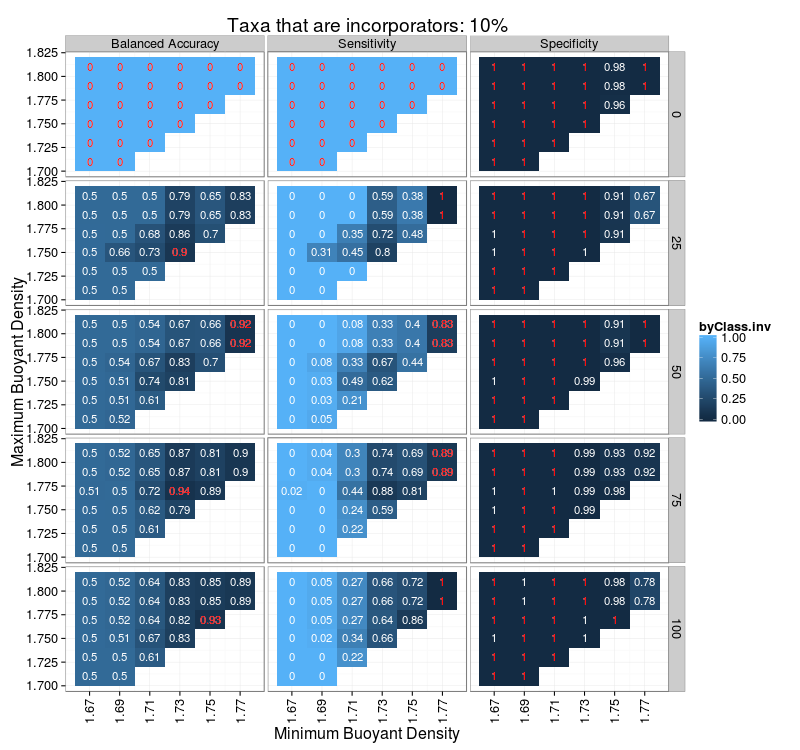

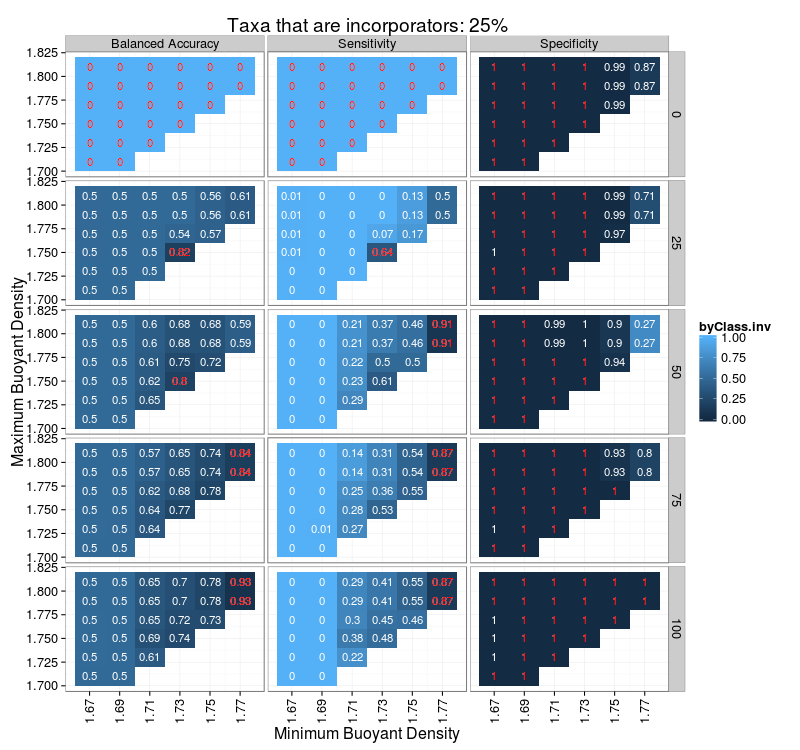

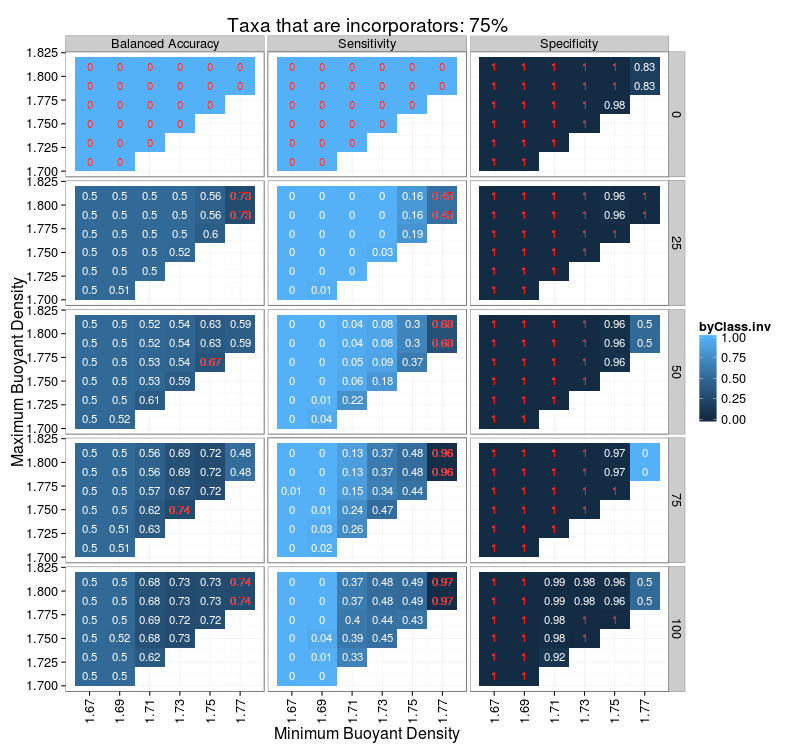

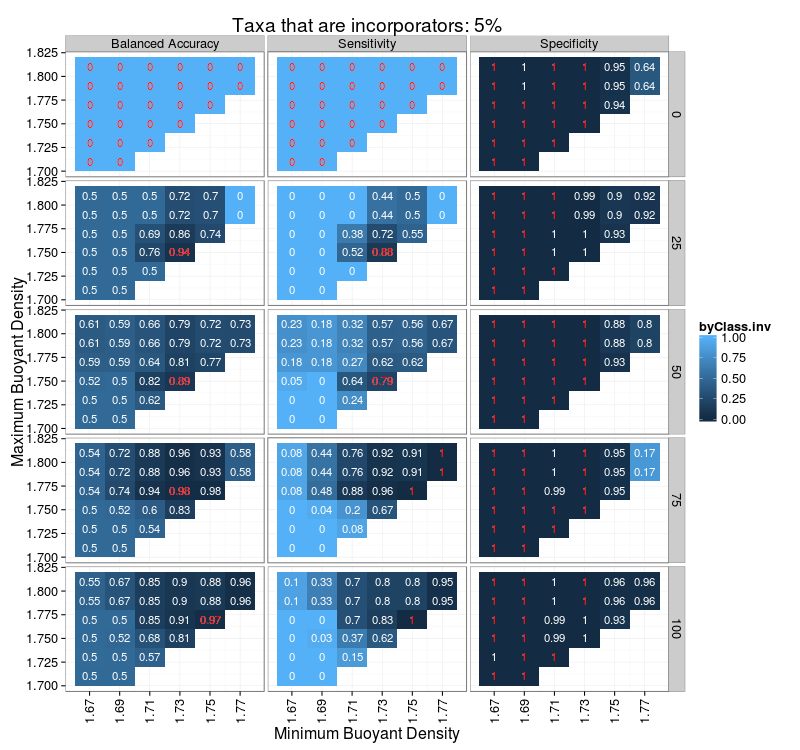

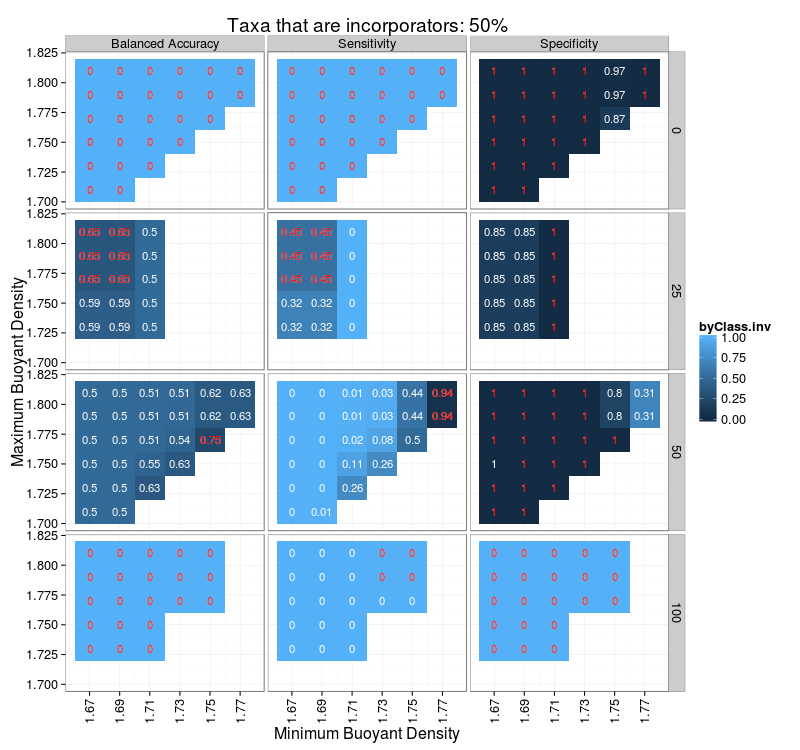

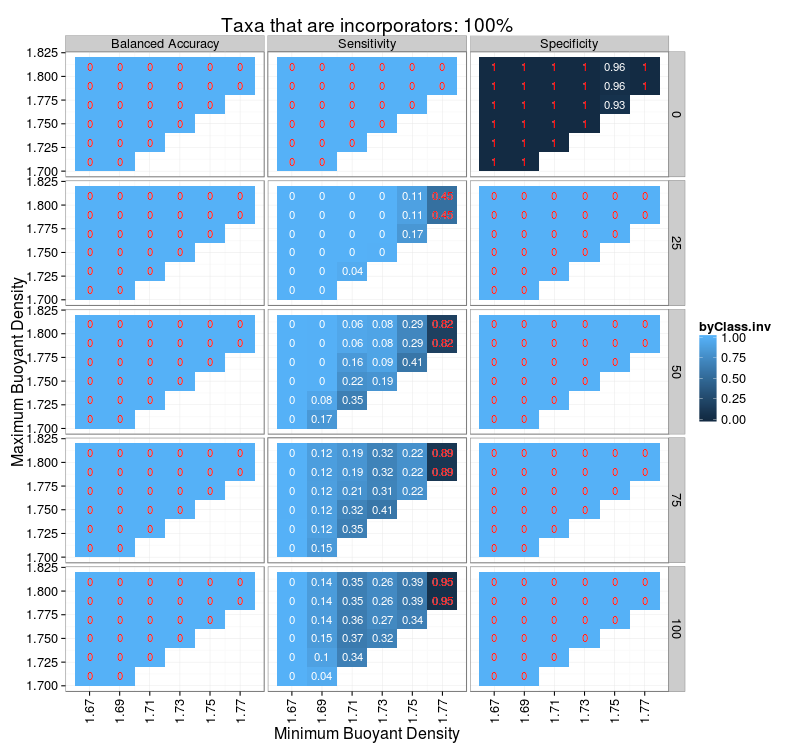

In [27]:
%%R -w 800 -h 750

x.breaks = unique(byClass.j$BD_min)

taxaIncorp = unique(byClass.j$percTaxaIncorp)

for (x in taxaIncorp){
    title = paste(c('Taxa that are incorporators: ', x, '%'), collapse='')
    
    tbl = byClass.j %>% filter(percTaxaIncorp == x)
    tbl2 = byClass.jf %>% filter(percTaxaIncorp == x)
    
     p = ggplot(tbl, aes(BD_min, BD_max, fill=byClass.inv)) +
     geom_tile() +
     geom_text(aes(label=byClass.txt), color=c('white'), size=4) +
     geom_text(data=tbl2, aes(label=byClass.txt), color=c('red'), size=4) +
     scale_x_continuous(breaks=x.breaks) +
     labs(x='Minimum Buoyant Density', y='Maximum Buoyant Density', title=title) +
     facet_grid(percIncorp ~ X) +
     theme_bw() +
     theme(
         text=element_text(size=16),
         axis.text.x=element_text(angle=90, hjust=1, vjust=0.5)
         )
    
     print(p)
    }


### Plotting false negative taxa (actual incorporators) 

In [243]:
%%R -i workDir

setwd(workDir)

tbl.c = read.csv('percIncorpUnif/50/DESeq2-cMtx_data.csv')

tbl.c.f = tbl.c %>% 
    filter(incorp.known==TRUE & incorp.pred==FALSE) %>%
    select(taxon)

write.table(tbl.c.f, file='percIncorpUnif/50/DESeq2-cMtx_FN', row.names=F, col.names=F, quote=F)

In [250]:
!cd $workDir'percIncorpUnif/50/'; \
    $R_dir/OTU_taxonAbund.r OTU_n2_abs1e8_sub30000.txt -t DESeq2-cMtx_FN -l -o DESeq2-cMtx_FN --width 14

File written: DESeq2-cMtx_FN_abs-abund.pdf
Warning messages:
1: Removed 48 rows containing missing values (position_stack). 
2: Removed 16 rows containing missing values (position_stack). 
File written: DESeq2-cMtx_FN_rel-abund.pdf


In [252]:
%%R -i workDir

setwd(workDir)

tbl.c = read.csv('percIncorpUnif/50/DESeq2-cMtx_data.csv')

tbl.c.f = tbl.c %>% 
    filter(incorp.known==FALSE & incorp.pred==TRUE) %>%
    select(taxon)

write.table(tbl.c.f, file='percIncorpUnif/50/DESeq2-cMtx_FP', row.names=F, col.names=F, quote=F)

In [253]:
!cd $workDir'percIncorpUnif/50/'; \
    $R_dir/OTU_taxonAbund.r OTU_n2_abs1e8_sub30000.txt -t DESeq2-cMtx_FP -l -o DESeq2-cMtx_FP --width 14

File written: DESeq2-cMtx_FP_abs-abund.pdf
Warning messages:
1: Removed 9 rows containing missing values (position_stack). 
2: Removed 3 rows containing missing values (position_stack). 
File written: DESeq2-cMtx_FP_rel-abund.pdf


In [256]:
%%R
tbl.c %>% filter(taxon %in% tbl.c.f$taxon)

  lib1 lib2                                    taxon BD_shift incorp.known
1   NA    2 Corynebacterium_pseudotuberculosis_FRC41        0        FALSE
2   NA    2            Anaplasma_centrale_str_Israel        0        FALSE
3   NA    2         Dyadobacter_fermentans_DSM_18053        0        FALSE
   baseMean log2FoldChange     lfcSE     stat       pvalue        padj
1 2.3478747       3.801071 0.8494856 4.474555 7.657045e-06 0.000344567
2 0.9337178       4.130228 1.0213776 4.043782 5.259585e-05 0.001183407
3 1.0835454       3.158858 0.8578349 3.682362 2.310831e-04 0.003466247
  incorp.pred
1        TRUE
2        TRUE
3        TRUE


### Enrichment of TP for abundant incorporators?

* What is the abundance distribution of TP and FP?
  * Are more abundant incorporators being detected more than low abundant taxa

In [200]:
%%R -i workDir

setwd(workDir)

tbl.c = read.csv('percIncorpUnif/100/DESeq2-cMtx_data.csv')
tbl.otu = read.delim('percIncorpUnif/100/OTU_n2_abs1e10_sub20000.txt', sep='\t')

In [201]:
%%R
# OTU total counts
tbl.otu.sum = tbl.otu %>%
    group_by(library, taxon) %>%
    summarize(total_count = sum(count))
tbl.otu.sum %>% head

Source: local data frame [6 x 3]
Groups: library

  library                                taxon total_count
1       1       Acaryochloris_marina_MBIC11017           0
2       1       Acetobacterium_woodii_DSM_1030           0
3       1 Acetobacter_pasteurianus_IFO_3283-12         751
4       1    Acetohalobium_arabaticum_DSM_5501           9
5       1         Acholeplasma_laidlawii_PG-8A         238
6       1        Achromobacter_xylosoxidans_A8          17


In [202]:
%%R
# 
label.tp.fn = function(known, pred){
    if(is.na(known) | is.na(pred)){
        return(NA)
        } else
    if(known==TRUE & pred==TRUE){
        return('TP')
        } else
    if(known==TRUE & pred==FALSE){
        return('FN')
        } else {
        return(NA)
        }
    }

tbl.c.tp.fn = tbl.c %>% 
    mutate(tp.fn = mapply(label.tp.fn, incorp.known, incorp.pred)) %>%
    filter(! is.na(tp.fn))

tbl.tp.fn = inner_join(tbl.c.tp.fn, tbl.otu.sum, c('taxon' = 'taxon')) 
tbl.tp.fn %>% head

  lib1 lib2                              taxon  BD_shift incorp.known  baseMean
1   NA    2 Actinobacillus_equuli_subsp_equuli 0.9999269         TRUE 1.8646755
2   NA    2 Actinobacillus_equuli_subsp_equuli 0.9999269         TRUE 1.8646755
3   NA    2 Candidatus_Moranella_endobia_PCVAL 0.9997449         TRUE 0.4688403
4   NA    2 Candidatus_Moranella_endobia_PCVAL 0.9997449         TRUE 0.4688403
5   NA    2     Alkaliphilus_oremlandii_OhILAs 0.9997434         TRUE 0.3118965
6   NA    2     Alkaliphilus_oremlandii_OhILAs 0.9997434         TRUE 0.3118965
  log2FoldChange    lfcSE       stat       pvalue       padj            p
1     5.37154211 1.267839 4.23676891 2.267593e-05 0.00111679 2.677315e-05
2     5.37154211 1.267839 4.23676891 2.267593e-05 0.00111679 2.677315e-05
3     0.04533956 1.501490 0.03019637 9.759104e-01 1.00000000 5.542099e-01
4     0.04533956 1.501490 0.03019637 9.759104e-01 1.00000000 5.542099e-01
5     5.33532814 1.665671 3.20311065 1.359517e-03 0.02434772 1.132750e

In [203]:
%%R
# how many TP & FN?
tbl.tp.fn %>% 
    group_by(library, tp.fn) %>%
    summarize(n = n())

Source: local data frame [4 x 3]
Groups: library

  library tp.fn  n
1       1    FN 63
2       1    TP  9
3       2    FN 63
4       2    TP  9


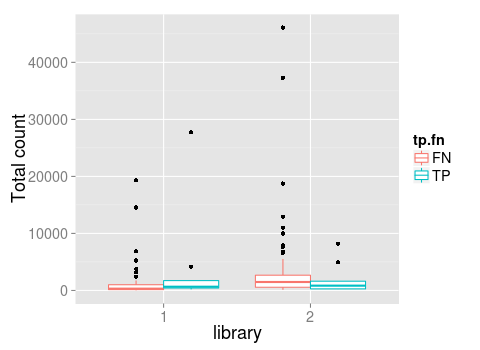

In [204]:
%%R -h 350
tbl.tp.fn$library = as.character(tbl.tp.fn$library)
ggplot(tbl.tp.fn, aes(library, total_count, color=tp.fn)) +
    geom_boxplot() +
    labs(y='Total count') +
    theme(
        text = element_text(size=18)
        )  

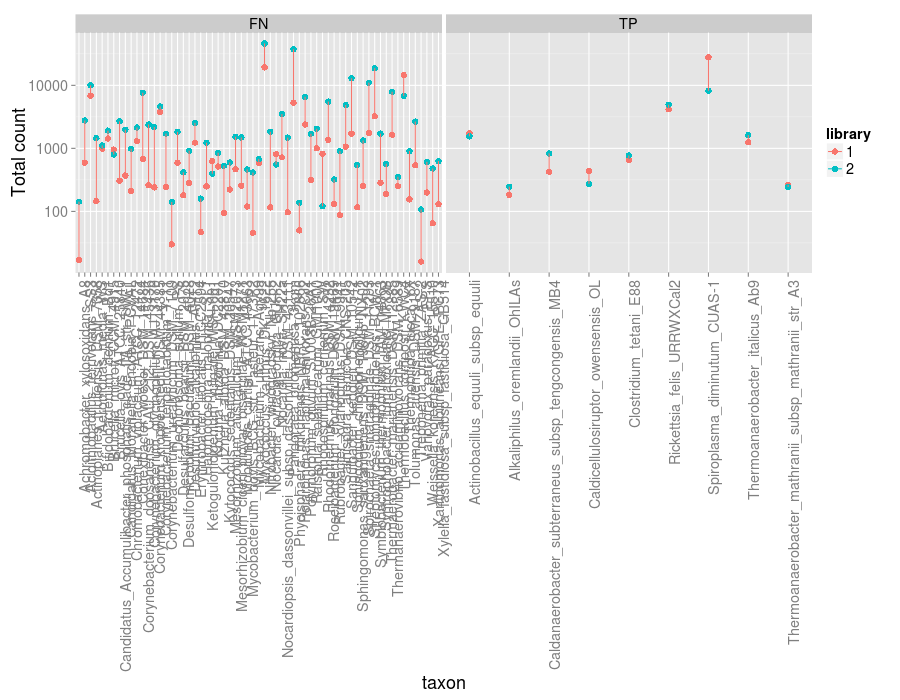

In [209]:
%%R -h 700 -w 900
tbl.tp.fn$library = as.character(tbl.tp.fn$library)
ggplot(tbl.tp.fn, aes(taxon, total_count, group=taxon, color=library)) +
    geom_point(size=3) +
    geom_line() +
    scale_y_log10() +
    labs(y='Total count') +
    facet_grid(. ~ tp.fn, scales='free_x') +
    theme(
        text = element_text(size=18),
        axis.text.x = element_text(angle=90, hjust=1)
        )  

__Notes:__

* FNs can be abundant
* __TP can have a lower abundance in the 'treatment' library__

### Just looking at the 'heavy' fractions

In [210]:
%%R
# OTU total counts

heavy.cut = 1.71

tbl.otu.sum = tbl.otu %>%
    filter(! grepl('inf', fraction)) %>%
    separate(fraction, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%
    filter(BD_min >= heavy.cut & BD_max <= 2) %>%
    group_by(library, taxon) %>%
    summarize(total_count = sum(count))
tbl.otu.sum %>% head

Source: local data frame [6 x 3]
Groups: library

  library                                taxon total_count
1       1       Acaryochloris_marina_MBIC11017           0
2       1       Acetobacterium_woodii_DSM_1030           0
3       1 Acetobacter_pasteurianus_IFO_3283-12         564
4       1    Acetohalobium_arabaticum_DSM_5501           0
5       1         Acholeplasma_laidlawii_PG-8A           0
6       1        Achromobacter_xylosoxidans_A8          17


In [211]:
%%R

tbl.tp.fn = inner_join(tbl.c.tp.fn, tbl.otu.sum, c('taxon' = 'taxon')) 
tbl.tp.fn %>% head

  lib1 lib2                              taxon  BD_shift incorp.known  baseMean
1   NA    2 Actinobacillus_equuli_subsp_equuli 0.9999269         TRUE 1.8646755
2   NA    2 Actinobacillus_equuli_subsp_equuli 0.9999269         TRUE 1.8646755
3   NA    2 Candidatus_Moranella_endobia_PCVAL 0.9997449         TRUE 0.4688403
4   NA    2 Candidatus_Moranella_endobia_PCVAL 0.9997449         TRUE 0.4688403
5   NA    2     Alkaliphilus_oremlandii_OhILAs 0.9997434         TRUE 0.3118965
6   NA    2     Alkaliphilus_oremlandii_OhILAs 0.9997434         TRUE 0.3118965
  log2FoldChange    lfcSE       stat       pvalue       padj            p
1     5.37154211 1.267839 4.23676891 2.267593e-05 0.00111679 2.677315e-05
2     5.37154211 1.267839 4.23676891 2.267593e-05 0.00111679 2.677315e-05
3     0.04533956 1.501490 0.03019637 9.759104e-01 1.00000000 5.542099e-01
4     0.04533956 1.501490 0.03019637 9.759104e-01 1.00000000 5.542099e-01
5     5.33532814 1.665671 3.20311065 1.359517e-03 0.02434772 1.132750e

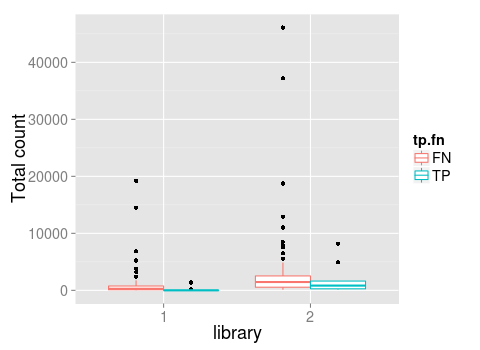

In [212]:
%%R -h 350
tbl.tp.fn$library = as.character(tbl.tp.fn$library)
ggplot(tbl.tp.fn, aes(library, total_count, color=tp.fn)) +
    geom_boxplot() +
    labs(y='Total count') +
    theme(
        text = element_text(size=18)
        )  

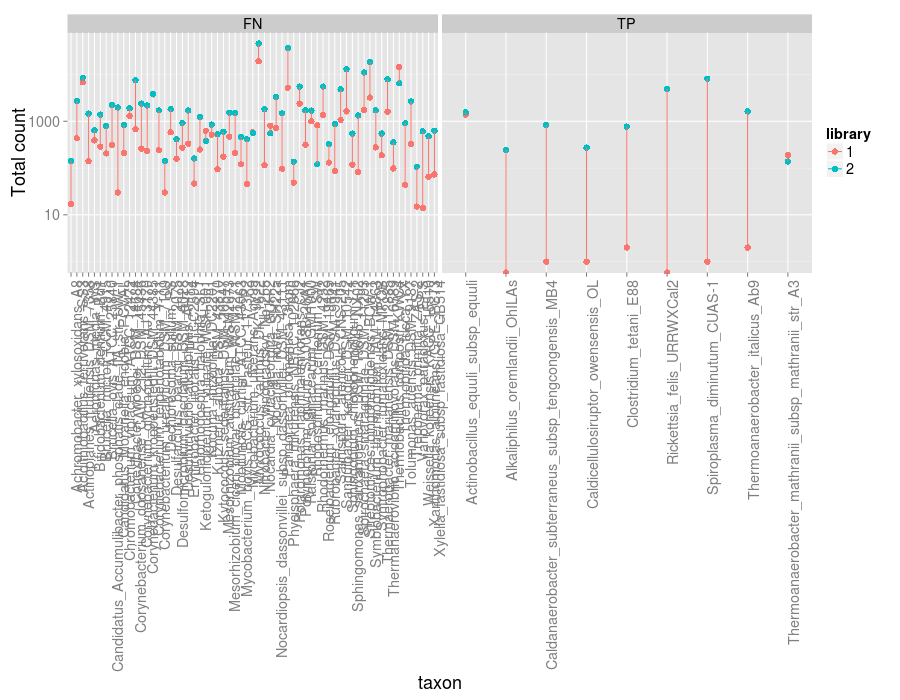

In [215]:
%%R -h 700 -w 900
tbl.tp.fn$library = as.character(tbl.tp.fn$library)
ggplot(tbl.tp.fn, aes(taxon, total_count, group=taxon, color=library)) +
    geom_point(size=3) +
    geom_line() +
    scale_y_log10() +
    labs(y='Total count') +
    facet_grid(. ~ tp.fn, scales='free_x') +
    theme(
        text = element_text(size=18),
        axis.text.x = element_text(angle=90, hjust=1)
        )  

In [ ]:
%%R -i workDir -w 1000 -h 450
setwd(workDir)

tbl.ds = read.csv('DESeq2-cMtx_data.csv')

# loading file
tbl.otu = read.delim('OTU_abs1e10.txt', sep='\t')

tbl.otu = tbl.otu %>% 
    filter(!grepl('inf', fraction, ignore.case=T)) %>%
    separate(fraction, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%

tbl.j = inner_join(tbl.otu, tbl.ds, c('taxon' = 'taxon'))

__Notes:__

* The TPs (for the most part) are dramatically different in abundance between control and treatment

***

# Sandbox

In [73]:
# building tree structure
from os.path import abspath
nest = nestly.Nest()

##  values
vals = [str(x) for x in range(1,5)]
nest.add('vals', vals)


## input files
nest.add('--np', [1], create_dir=False)

buildDir = '/home/nick/t/nestly/' #os.path.join(workDir, 'vals')
nest.build(buildDir)

In [74]:
%%writefile /home/nick/t/example.sh
#!/bin/bash

export TIME='elapsed,maxmem,exitstatus\n%e,%M,%x'

echo {--np} > {--np}_test.txt

Writing /home/nick/t/example.sh


In [75]:
!cd /home/nick/t/; \
    chmod 777 example.sh 

In [76]:
!cd /home/nick/t/; \
    nestrun -j 2 --template-file example.sh -d nestly

2015-06-24 12:13:25,688 * INFO * Template: ./example.sh
2015-06-24 12:13:25,690 * INFO * [204263] Started ./example.sh in nestly/3
2015-06-24 12:13:25,692 * INFO * [204264] Started ./example.sh in nestly/2
2015-06-24 12:13:25,692 * INFO * [204263] nestly/3 Finished with 0
2015-06-24 12:13:25,694 * INFO * [204265] Started ./example.sh in nestly/1
2015-06-24 12:13:25,694 * INFO * [204264] nestly/2 Finished with 0
2015-06-24 12:13:25,696 * INFO * [204266] Started ./example.sh in nestly/4
2015-06-24 12:13:25,696 * INFO * [204265] nestly/1 Finished with 0
2015-06-24 12:13:25,696 * INFO * [204266] nestly/4 Finished with 0


In [120]:
%%writefile $bashFile
#!/bin/bash


#-- R analysis --#
export PATH={R_dir}:$PATH
# plotting taxon abundances
OTU_taxonAbund.r \
    OTU_n2_abs{abs}_sub{subsample}.txt \
    -r {topTaxaToPlot} \
    -o OTU_n2_abs{abs}_sub{subsample} 
# running DeSeq2 and making confusion matrix on predicting incorporators
## making phyloseq object from OTU table
phyloseq_make.r \
    OTU_n2_abs{abs}_sub{subsample}_w.txt \
    -s OTU_n2_abs{abs}_sub{subsample}_meta.txt \
    > OTU_n2_abs{abs}_sub{subsample}.physeq
## filtering phyloseq object to just taxa/samples of interest
phyloseq_edit.r \
    OTU_n2_abs{abs}_sub{subsample}.physeq \
    --BD_min {BD_min} --BD_max {BD_max} \
    > OTU_n2_abs{abs}_sub{subsample}_filt.physeq
## making ordination
phyloseq_ordination.r \
    OTU_n2_abs{abs}_sub{subsample}_filt.physeq \
    OTU_n2_abs{abs}_sub{subsample}_bray-NMDS.pdf
## DESeq2
phyloseq_DESeq2.r \
    OTU_n2_abs{abs}_sub{subsample}_filt.physeq \
    > OTU_n2_abs{abs}_sub{subsample}_DESeq2
## Confusion matrix
DESeq2_confuseMtx.r \
    {fileName}_kde_dif_incorp_BD-shift.txt \
    OTU_n2_abs{abs}_sub{subsample}_DESeq2 \
    --padj {padj} --log2 {log2} 
    
    

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1210/SIPSimRun.sh
